# 0.9142

In [1]:
#상위 폴더 load_data파일 불러오기 위해 경로 추가
import sys
sys.path.append('../')  # 상위 폴더(main_folder)의 경로를 추가

# 데이터 가져오기
from load_data import load_data

# 사용자 지정 함수 불러오기
from eval import get_Accuracy_tf

# 텐서플로
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as Layer

# 콜백
from timeit import default_timer as timer

In [2]:
# 랜덤시드 고정
tf.random.set_seed(42)

In [3]:
# MinMaxScaler - 0, StandardScaler - 1, , MaxAbsScaler - 2, RobustScaler - 3, Normalizer - 4
X_train0, X_val0, X_test0, y_train0, y_val0, y_test0, scaler0  = load_data(scaler=0)
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1, scaler1  = load_data(scaler=1)
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2, scaler2  = load_data(scaler=2)
X_train3, X_val3, X_test3, y_train3, y_val3, y_test3, scaler3  = load_data(scaler=3)
X_train4, X_val4, X_test4, y_train4, y_val4, y_test4, scaler4  = load_data(scaler=4)

X_train1.shape, X_val1.shape, X_test2.shape, y_train2.shape, y_val2.shape, y_test2.shape, scaler2



((2672, 10), (669, 10), (836, 10), (2672,), (669,), (836,), MaxAbsScaler())

In [8]:
class EvalAccuracy(tf.keras.metrics.Metric):
    """
    사용자 정의 평가지표 : Accuracy
    """
    def __init__(self, name="accuracy", **kwargs):
        super(EvalAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name=name, initializer="zeros")

    def update_state(self, y_true, y_predict, sample_weight=None):
        value = tf.abs((y_predict - y_true) / y_true)
        self.correct.assign(tf.reduce_mean(value))

    def result(self):
        return 1 - self.correct

    def reset_state(self):
        self.correct.assign(0.)

def get_model(shape=len(X_train0.columns), node_n=12, dout=0.01):
    regularizer=keras.regularizers.L1L2(l1=0.001, l2=0.001)
    
    inputs  = keras.Input(shape=shape)
    
    dense1  = keras.layers.Dense(node_n, kernel_regularizer=regularizer)(inputs)
    norm1   = keras.layers.BatchNormalization()(dense1)
    relu1   = keras.layers.Activation('relu')(norm1)
    dout1   = keras.layers.Dropout(dout)(relu1)
    
    dense2  = keras.layers.Dense(node_n*2, kernel_regularizer=regularizer)(dout1)
    norm2   = keras.layers.BatchNormalization()(dense2)
    relu2   = keras.layers.Activation('relu')(norm2)
    dout2   = keras.layers.Dropout(dout)(relu2)
    
    dense3  = keras.layers.Dense(node_n*4, kernel_regularizer=regularizer)(dout2)
    norm3   = keras.layers.BatchNormalization()(dense3)
    relu3   = keras.layers.Activation('relu')(norm3)
    dout3   = keras.layers.Dropout(dout)(relu3)
    
    dense4  = keras.layers.Dense(node_n*8, kernel_regularizer=regularizer)(dout3)
    norm4   = keras.layers.BatchNormalization()(dense4)
    relu4   = keras.layers.Activation('relu')(norm4)
    dout4   = keras.layers.Dropout(dout)(relu4)
    
    dense5  = keras.layers.Dense(node_n*16, kernel_regularizer=regularizer)(dout4)
    norm5   = keras.layers.BatchNormalization()(dense5)
    relu5   = keras.layers.Activation('relu')(norm5)
    dout5   = keras.layers.Dropout(dout)(relu5)
    
    concat1  = keras.layers.Concatenate(axis=1)([dout5, dout4])
    dense6  = keras.layers.Dense(node_n*8, kernel_regularizer=regularizer)(concat1)
    norm6   = keras.layers.BatchNormalization()(dense6)
    relu6   = keras.layers.Activation('relu')(norm6)
    dout6   = keras.layers.Dropout(dout)(relu6)
    
    concat2  = keras.layers.Concatenate(axis=1)([dout6, dout3])
    dense7  = keras.layers.Dense(node_n*4, kernel_regularizer=regularizer)(concat2)
    norm7   = keras.layers.BatchNormalization()(dense7)
    relu7   = keras.layers.Activation('relu')(norm7)
    dout7   = keras.layers.Dropout(dout)(relu7)
    
    concat3  = keras.layers.Concatenate(axis=1)([dout7, dout2])
    dense8  = keras.layers.Dense(node_n*2, kernel_regularizer=regularizer)(concat3)
    norm8   = keras.layers.BatchNormalization()(dense8)
    relu8   = keras.layers.Activation('relu')(norm8)
    dout8   = keras.layers.Dropout(dout)(relu8)
    
    concat4  = keras.layers.Concatenate(axis=1)([dout8, dout1])
    dense9  = keras.layers.Dense(node_n, kernel_regularizer=regularizer)(concat4)
    norm9   = keras.layers.BatchNormalization()(dense9)
    relu9   = keras.layers.Activation('relu')(norm9)
    dout9   = keras.layers.Dropout(dout)(relu9)
    
    outputs = keras.layers.Dense(1)(dout9)
    model   = keras.Model(inputs, outputs, name='Abalone_Model')
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.MeanSquaredError(),
        metrics=[EvalAccuracy()]
        )
    return model

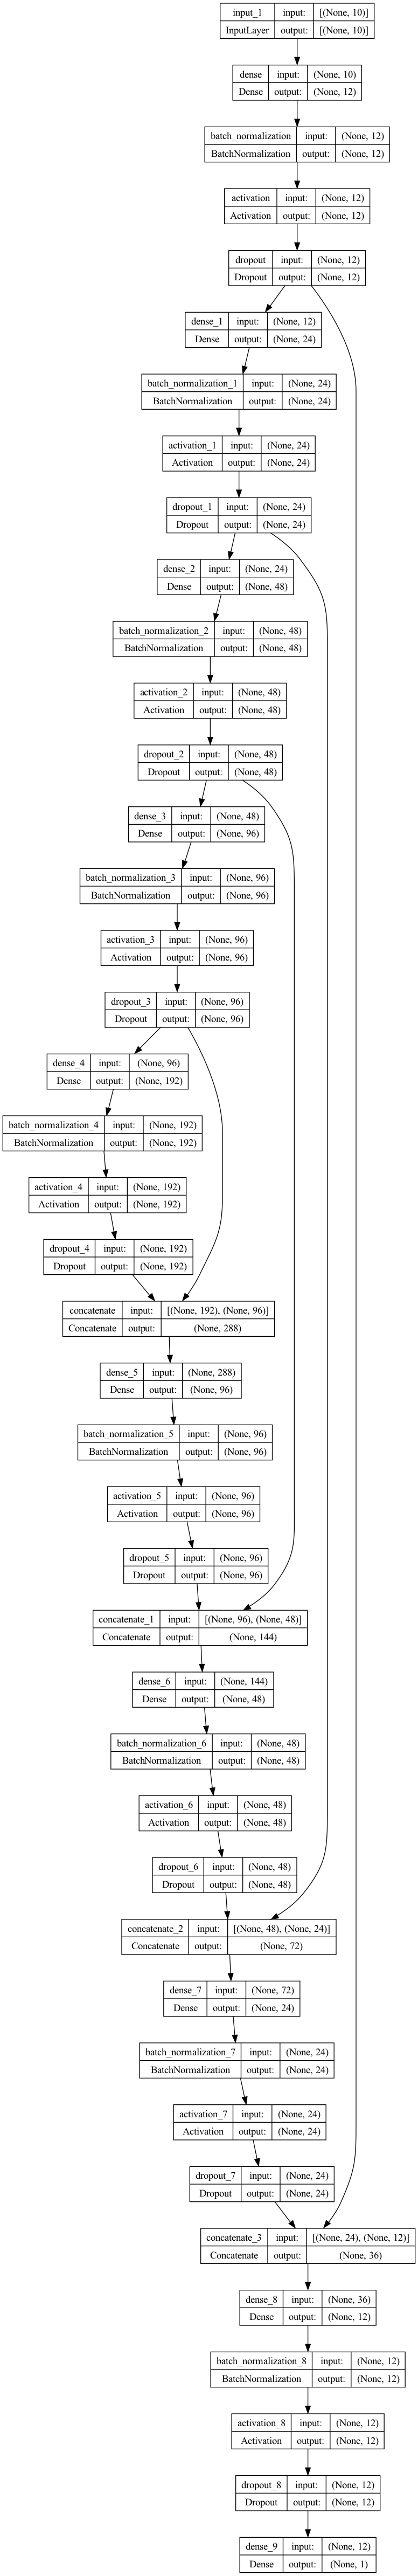

In [7]:
model = get_model()
keras.utils.plot_model(model, show_shapes=True)

In [9]:

# 학습 소요 시간 표시 콜백용 class 정의
class TimingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting training")
        self.starttime = timer()

    def on_train_end(self, logs=None):
        print("End of training, took {} seconds".format(timer()-self.starttime))

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
          print("Epoch is {} and {} seconds passed".format(epoch, timer()-self.starttime))

In [11]:
check_path = 'model_weight.h5'

callback = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50),
    tf.keras.callbacks.ModelCheckpoint(filepath=check_path, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=200, min_lr=0.001),
    TimingCallback()
]

In [12]:
history0 = model.fit(X_train0, y_train0, batch_size= 1024, epochs= 1000,  validation_data=(X_val0, y_val0), callbacks=callback,verbose = 0)
results0 = model.evaluate(X_test0, y_test0)

Starting training
Epoch is 0 and 1.1717381251510233 seconds passed
Epoch is 10 and 1.6271508340723813 seconds passed
Epoch is 20 and 2.1455257500056177 seconds passed
Epoch is 30 and 2.6416217091027647 seconds passed
Epoch is 40 and 3.162628750083968 seconds passed
Epoch is 50 and 3.69079195917584 seconds passed
Epoch is 60 and 4.2199664590880275 seconds passed
Epoch is 70 and 4.747786249965429 seconds passed
Epoch is 80 and 5.275388584006578 seconds passed
Epoch is 90 and 5.8001921670511365 seconds passed
Epoch is 100 and 6.329933625180274 seconds passed
Epoch is 110 and 6.859400917077437 seconds passed
Epoch is 120 and 7.374810375040397 seconds passed
Epoch is 130 and 7.891185542102903 seconds passed
Epoch is 140 and 8.416865875013173 seconds passed
Epoch is 150 and 8.938807709142566 seconds passed
Epoch is 160 and 9.446663542184979 seconds passed
Epoch is 170 and 9.955711791990325 seconds passed
Epoch is 180 and 10.475094750057906 seconds passed
Epoch is 190 and 10.95346216717735 se

In [13]:
history1 = model.fit(X_train1, y_train1, batch_size= 1024, epochs= 1000,  validation_data=(X_val1, y_val1), callbacks=callback,verbose = 0)
results1 = model.evaluate(X_test1, y_test1)

Starting training
Epoch is 0 and 0.07531258277595043 seconds passed
Epoch is 10 and 0.5317481248639524 seconds passed
Epoch is 20 and 0.9749130408745259 seconds passed
Epoch is 30 and 1.4210572908632457 seconds passed
Epoch is 40 and 1.8611012499313802 seconds passed
Epoch is 50 and 2.35838154098019 seconds passed
Epoch is 60 and 2.8105210829526186 seconds passed
Epoch is 70 and 3.269934707786888 seconds passed
Epoch is 80 and 3.737099915975705 seconds passed
Epoch is 90 and 4.1919898327905685 seconds passed
Epoch is 100 and 4.656854999950156 seconds passed
Epoch is 110 and 5.095647624926642 seconds passed
Epoch is 120 and 5.537491458002478 seconds passed
Epoch is 130 and 5.977998249931261 seconds passed
Epoch is 140 and 6.422545540845022 seconds passed
Epoch is 150 and 6.924237165832892 seconds passed
End of training, took 6.924346707994118 seconds
27/27 [==============================] - 0s 551us/step - loss: 7.6196 - accuracy: 0.9091


In [14]:
history2 = model.fit(X_train2, y_train2, batch_size= 1024, epochs= 1000,  validation_data=(X_val2, y_val2), callbacks=callback,verbose = 0)
results2 = model.evaluate(X_test2, y_test2)

Starting training
Epoch is 0 and 0.0712404998484999 seconds passed
Epoch is 10 and 0.5256202078890055 seconds passed
Epoch is 20 and 0.976972582982853 seconds passed
Epoch is 30 and 1.4247083750087768 seconds passed
Epoch is 40 and 1.8680234160274267 seconds passed
Epoch is 50 and 2.3161868329625577 seconds passed
Epoch is 60 and 2.7588416659273207 seconds passed
Epoch is 70 and 3.196053290972486 seconds passed
Epoch is 80 and 3.636511707911268 seconds passed
Epoch is 90 and 4.079868708038703 seconds passed
Epoch is 100 and 4.523138124961406 seconds passed
Epoch is 110 and 4.965679624816403 seconds passed
Epoch is 120 and 5.404631832847372 seconds passed
Epoch is 130 and 5.844575583003461 seconds passed
End of training, took 6.107812125002965 seconds
27/27 [==============================] - 0s 555us/step - loss: 8.3667 - accuracy: 0.8249


In [15]:
history3 = model.fit(X_train3, y_train3, batch_size= 1024, epochs= 1000,  validation_data=(X_val3, y_val3), callbacks=callback,verbose = 0)
results3 = model.evaluate(X_test3, y_test3)

Starting training
Epoch is 0 and 0.06700283382087946 seconds passed
Epoch is 10 and 0.5078647918999195 seconds passed
Epoch is 20 and 0.9779587499797344 seconds passed
Epoch is 30 and 1.4793959588278085 seconds passed
Epoch is 40 and 1.9330455840099603 seconds passed
Epoch is 50 and 2.3853454999625683 seconds passed
Epoch is 60 and 2.831399083836004 seconds passed
Epoch is 70 and 3.2910214588046074 seconds passed
Epoch is 80 and 3.7644345418084413 seconds passed
Epoch is 90 and 4.2543962087947875 seconds passed
Epoch is 100 and 4.721363833872601 seconds passed
End of training, took 4.8137266668491066 seconds
27/27 [==============================] - 0s 680us/step - loss: 7.2140 - accuracy: 0.9105


In [16]:
history4 = model.fit(X_train4, y_train4, batch_size= 1024, epochs= 1000,  validation_data=(X_val4, y_val4), callbacks=callback,verbose = 0)
results4 = model.evaluate(X_test4, y_test4)

Starting training
Epoch is 0 and 0.0788536670152098 seconds passed
Epoch is 10 and 0.553879874991253 seconds passed
Epoch is 20 and 1.048507999861613 seconds passed
Epoch is 30 and 1.521950124995783 seconds passed
Epoch is 40 and 1.98524916684255 seconds passed
Epoch is 50 and 2.446564457844943 seconds passed
Epoch is 60 and 2.911176374880597 seconds passed
Epoch is 70 and 3.3843194579239935 seconds passed
Epoch is 80 and 3.8487531668506563 seconds passed
Epoch is 90 and 4.3290968330111355 seconds passed
Epoch is 100 and 4.774304791819304 seconds passed
Epoch is 110 and 5.242434999905527 seconds passed
Epoch is 120 and 5.688677291851491 seconds passed
Epoch is 130 and 6.149301916826516 seconds passed
Epoch is 140 and 6.615489666815847 seconds passed
Epoch is 150 and 7.066853791940957 seconds passed
Epoch is 160 and 7.517619249876589 seconds passed
Epoch is 170 and 7.969577249838039 seconds passed
Epoch is 180 and 8.412921832874417 seconds passed
End of training, took 8.589537666877732 